## GPT Classifier
In this pipeline we will classify as relevant or not each element of the test-set

In [ ]:
import json

from dotenv import load_dotenv
import os

os.chdir("..")
os.getcwd()
load_dotenv()

print(os.getcwd())

In [1]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection", split="test")
test_df = test.to_pandas()

### Comparison between Eathus data and DanCip data

In [ ]:
from datasets import load_dataset

test_dan = load_dataset("DanCip/github-issues-vul-detection", split="test")
test_df_dan = test_dan.to_pandas()

In [ ]:
print("len(test_df_dan):", len(test_df_dan))
print("len(test_df):", len(test_df))

print("Dan posetive count:", len(test_df_dan[test_df_dan['label']]))
print("Eathus posetive count:", len(test_df[test_df['label']]))

## Zero-shot learning

In [2]:
# Cost only of the input
(test_df.issue_msg_n_tokens.sum() / 1000000) * 0.15

np.float64(0.50932515)

In [23]:
from utils import *
import os
from langchain_groq import ChatGroq  # Groq's LangChain integration
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

GROQ_API_KEY = os.getenv("GROQ_API_KEY")

class ReplySchema(BaseModel):
    gpt_description: str = Field(
        description="Describe the vulnerability detected, if any; otherwise, write None"
    )
    gpt_vulnerability: str = Field(
        description="Describe the general type of vulnerability detected, if any; otherwise, write None"
    )
    gpt_confidence: int = Field(
        description="An integer from 1 to 5 indicating your level of confidence  (1 = very low, 2 = low, 3 = medium, 4 = high, 5 = very high)."
    )
    gpt_is_relevant: bool = Field(
        description="Boolean that states if there is a vulnerability"
    )

'''
llm = ChatGroq(
    temperature=0.0,
    model_name="llama3-70b-8192",  # Groq's fastest Llama 3 70B endpoint
    api_key=GROQ_API_KEY     # Replace with your Groq key
)
'''

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0, max_tokens=15500) # maybe set max_token to 14000

prompts_dict = load_prompts(os.getcwd() + "/prompts")

prompt = ChatPromptTemplate.from_messages(
    [("system", prompts_dict["system_setupd_detailed_desc"]), ("human", "{msg}")],
)


def parser(message: ReplySchema):
    return message.model_dump_json()


llm = llm.with_structured_output(ReplySchema)
chain = prompt | llm | parser

In [19]:
print(prompt.messages[1])

prompt=PromptTemplate(input_variables=['msg'], input_types={}, partial_variables={}, template='{msg}') additional_kwargs={}


In [24]:
import tiktoken
from langchain_core.messages import HumanMessage, SystemMessage

# --- Token counting function ---
def count_tokens(messages, model_name="gpt-4"):
    enc = tiktoken.encoding_for_model(model_name)
    total_tokens = 0
    for msg in messages:
        role_tokens = 4  # system/human/assistant structure adds overhead
        total_tokens += role_tokens + len(enc.encode(msg.content))
    total_tokens += 2  # additional overhead for the assistant priming
    return total_tokens

example_input = "Here's a snippet of Python code to check for vulnerabilities."
filled_prompt = prompt.format_messages(msg=example_input)
# --- Count tokens in the filled prompt ---
token_count = count_tokens(filled_prompt)
print(f"Token count for prompt: {token_count}")

Token count for prompt: 472


In [9]:
example = chain.invoke('''This is a GitHub Issue\nrepo: ZipArchive\nowner: ZipArchive\nTitle : Unhandled edge case in _sanitizedPath #680 \n\n--- start body ---\nDescription:\n\nThere is an unhandeled edge case where we can crash the application when it tries to unzip a specially crafted zip file\n\nTechnical details:\n\nBelow is a code snippet from the _sanitizedPath function used to sanitize file paths coming from zip entries before extraction to prevent path traversal, the function prepends file:/// to the provided path, standardizes it using NSURL and then removes the prepended file:///, when provided with the following path however /.., the standardized path returned by NSURL becomes file://, which has 7 characters, the package however expects at least 8 characters (length of the prepended text), this results in crashing the application.\n\n// Add scheme \"file:///\" to support sanitation on names with a colon like \"file:a/../../../usr/bin\"\nstrPath = [@\"file:///\" stringByAppendingString:strPath];\n\n// Sanitize path traversal characters to prevent directory backtracking. Ignoring these characters mimicks the default behavior of the Unarchiving tool on macOS.\n// \"../../../../../../../../../../../tmp/test.txt\" -> \"tmp/test.txt\"\n// \"a/b/../c.txt\" -> \"a/c.txt\"\nstrPath = [NSURL URLWithString:strPath].standardizedURL.absoluteString;\n\n// Remove the \"file:///\" scheme\nstrPath = [strPath substringFromIndex:8];\nPoC:\n\nimport zipfile\n\ndef compress_file(filename):\n    with zipfile.ZipFile('payload.zip', 'w') as zipf:\n        zipf.writestr(filename, \"Test payload\")\n\nfilename = '/..'\n\ncompress_file(filename)\n--- end body ---''')

In [10]:
import json
import pandas as pd

examplej = json.loads(example)

In [11]:
from IPython.display import display, Markdown, Latex
display(Markdown(examplej['gpt_vulnerability']))

# Denial of Service (DoS) Vulnerability
## Description
A Denial of Service (DoS) vulnerability occurs when an attacker can cause a system to become unavailable to legitimate users, typically by crashing the application or exhausting resources.
## Extended Description
In this case, the application crashes when it encounters a specific input that the sanitization function does not handle properly. This can be exploited by an attacker to create a specially crafted zip file that, when processed, leads to application failure.
## Demonstrative Scenario
### Scenario
An attacker creates a zip file containing a path that triggers the unhandled edge case in the _sanitizedPath function, causing the application to crash when it attempts to extract the contents.
### Vulnerable Objective-C Code:
```objective-c
// Add scheme "file:///" to support sanitation on names with a colon like "file:a/../../../usr/bin"
strPath = [@"file:///" stringByAppendingString:strPath];

// Sanitize path traversal characters to prevent directory backtracking.
strPath = [NSURL URLWithString:strPath].standardizedURL.absoluteString;

// Remove the "file:///" scheme
strPath = [strPath substringFromIndex:8];
```
### Analysis
The vulnerability arises from the assumption that the standardized URL will always return a string of sufficient length. When the input is '/..', the resulting string is 'file://', which is only 7 characters long. The subsequent call to substringFromIndex:8 leads to an out-of-bounds error, causing the application to crash. This demonstrates a failure to validate input properly, leading to a Denial of Service condition.

In [30]:
from utils import *
from pandarallel import pandarallel
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from openai import OpenAIError, RateLimitError  # Explicitly import errors

pandarallel.initialize(progress_bar=True, nb_workers=15)

@retry(
    stop=stop_after_attempt(5),  # Retry up to 5 times
    wait=wait_exponential(multiplier=2, min=1, max=60),  # Exponential backoff
    retry=retry_if_exception_type(RateLimitError),  # Retry only on rate limit errors
)
def _gpt_classify(msg):
    if not msg or not isinstance(msg, str):  # Check for empty/invalid messages
        return None
    return chain.invoke({"msg": msg})  # Adjusted for OpenAI API format

def gpt_classify(msg):
    try:
        return _gpt_classify(msg)
    except OpenAIError as e:  # Catch all OpenAI-specific errors
        print(f"OpenAI API error: {e}")
    except Exception as e:
        print(f"General error processing message: {e}")
    return None


INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
import pickle
import os
file_path = "tmp/gpt_response_zero_cwe_df.pkl"

# Define the path to your pickle file

# Check if the file exists
if os.path.exists(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    print("Pickle file loaded successfully!")
else:
    print(f"The file at {file_path} does not exist. Setting gpt_response to 'None'")
    test_df['gpt_response'] = None



Pickle file loaded successfully!


In [1]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection-gpt-zero-results", split="test")
test_df = test.to_pandas()

README.md:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/35.7M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1778 [00:00<?, ? examples/s]

In [5]:
import json
import pandas as pd

# Step 1: Combine the normalized columns back into a dictionary
test_df['gpt_response'] = test_df.apply(
    lambda row: json.dumps({
        'gpt_description': row['gpt_description'],
        'gpt_confidence': row['gpt_confidence'],
        'gpt_is_relevant': row['gpt_is_relevant']
    }) if pd.notna(row['gpt_description']) else None,
    axis=1
)

# Step 2: Drop the individual normalized columns (optional)
test_df = test_df.drop(columns=['gpt_description', 'gpt_confidence', 'gpt_is_relevant'])

In [ ]:
len(test_df[test_df.gpt_response.isna()])

In [32]:
import pickle 
import time

retries = 0
max_retries = 10
file_path = "tmp/gpt_response_zero_cwe_df.pkl"
DELAY = 60 
#test_df['gpt_response'] = None
while not test_df[test_df.gpt_response.isna()].empty and retries < max_retries :
    # Get indices of rows needing processing
    na_indices = test_df[test_df.gpt_response.isna()].index
    
    if len(na_indices) == 0:
        break
    
    # Process ONLY those rows and assign directly to original DF
    test_df.loc[na_indices, 'gpt_response'] = \
        test_df.loc[na_indices, 'issue_msg'].parallel_apply(gpt_classify)
    
    with open(file_path, "wb") as file:  # 'wb' mode writes in binary format
        pickle.dump(test_df, file)
    retries += 1
    print(f"Retry {retries}: Processed {len(na_indices)} rows")
    time.sleep(DELAY)

General error processing message: RetryError[<Future at 0x7f3dfc49e8d0 state=finished raised RateLimitError>]
OpenAI API error: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=108, prompt_tokens=1986, total_tokens=2094, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
General error processing message: RetryError[<Future at 0x7f3dfc49eba0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7f3dfc4bfaa0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7f3dfdfee780 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7f3df751ffe0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7f3dfc

Retry 2: Processed 14 rows


In [34]:
print(*test_df.sample(3)['gpt_response'])
display(test_df.sample(3)['gpt_response'])

{"gpt_description":"The issue describes a stack overflow occurring in the `GetCodecString` method of the `AP4_AvcSampleDescription` class. This is likely due to a recursive call that does not have a proper base case, leading to excessive memory consumption and eventually crashing the program. Such stack overflows can be exploited to cause denial of service or potentially execute arbitrary code if the overflow can be controlled. Therefore, this indicates a potential security vulnerability.","gpt_vulnerability":"# Stack Overflow\n## Description\nA stack overflow occurs when a program uses more stack memory than is allocated, typically due to excessive recursion or deep function calls without a proper exit condition.\n## Extended Description\nStack overflows can lead to crashes and can be exploited in certain contexts to execute arbitrary code or cause denial of service. They often arise from programming errors such as infinite recursion or excessive memory allocation on the stack.\n## De

1604    {"gpt_description":"The issue discusses the pr...
1764    {"gpt_description":"The issue describes a prob...
126     {"gpt_description":"The issue describes a prob...
Name: gpt_response, dtype: object

In [37]:
import json
import pandas as pd

test_df['gpt_response'] = test_df['gpt_response'].map(
    lambda x: json.loads(x) if pd.notna(x) else None
)

In [38]:
print(*test_df.sample(3)['gpt_response'])
display(type(test_df['gpt_response'][0]))

{'gpt_description': 'The issue discusses a request to embed the `espeak-ng-data` folder within the espeak C library for use in another project. This request does not indicate any security vulnerability; rather, it is a feature request related to functionality and integration. There are no indications of security risks or vulnerabilities present in this issue.', 'gpt_vulnerability': 'None', 'gpt_confidence': 5, 'gpt_is_relevant': False} {'gpt_description': 'The issue discusses simplifying the watch cache implementation in Kubernetes by removing a redundant method and replacing it with another. It focuses on code maintenance and performance optimization rather than security. There are no indications of a security vulnerability present in this issue.', 'gpt_vulnerability': 'None', 'gpt_confidence': 5, 'gpt_is_relevant': False} {'gpt_description': 'The issue discusses a potential out-of-bounds access in the processing of WAV files due to the manipulation of `wav_factor` in the `DoSample2` 

dict

In [39]:
import pandas as pd

tmp = pd.json_normalize(test_df["gpt_response"])
test_df = pd.concat([test_df.drop(columns=["gpt_response"]), tmp], axis=1)

In [43]:
display(test_df.head())

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding,__index_level_0__,gpt_description,gpt_vulnerability,gpt_confidence,gpt_is_relevant
0,None,None,None,None,None,None,No_CWE,None,"[llvm, llvm-project]",I don't think we are using `std::memcmp` in `l...,...,129325,False,This is a GitHub Issue\nrepo:llvm-project\nown...,297,"[0.0001077328051906079, 0.0041412957943975925,...",4464,The issue discusses the optimization of the `s...,None,5,False
1,None,None,None,None,None,None,No_CWE,None,"[cesanta, mjs]",# s2o\r\n## Environment\r\nUbuntu 22.04.3 LTS\...,...,281,False,This is a GitHub Issue\nrepo:mjs\nowner:cesant...,1673,"[-0.01231892965734005, -0.0185470562428236, 0....",3444,The issue describes a segmentation fault (SEGV...,# Memory Corruption\n## Description\nMemory co...,4,True
2,None,None,None,None,None,None,No_CWE,None,"[xuxueli, xxl-job]",1. 提供创建、修改、查询、删除任务的openapi，带页面支持签名验签\n2. app启动...,...,3641,False,This is a GitHub Issue\nrepo:xxl-job\nowner:xu...,181,"[0.02733539044857025, -0.015366464853286743, -...",4204,The issue describes a feature request for an O...,None,5,False
3,None,None,None,None,None,None,No_CWE,None,"[gpac, gpac]","Excuse me, I want to ask how to call [session....",...,2241,False,This is a GitHub Issue\nrepo:gpac\nowner:gpac\...,391,"[-0.036246322095394135, 0.033608801662921906, ...",1513,The issue describes a user inquiry about how t...,None,5,False
4,CVE-2021-39528,2021-09-20T16:15:12.077,An issue was discovered in libredwg through v0...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,415,"[Exploit, Issue Tracking, Patch, Third Party A...","[LibreDWG, libredwg]","## System info\r\n\r\nUbuntu X64, gcc (Ubuntu ...",...,256,True,This is a GitHub Issue\nrepo:libredwg\nowner:L...,2400,"[-0.03039676696062088, 0.01844700239598751, -0...",308,The issue describes a double free vulnerabilit...,# Double Free Vulnerability\n## Description\nA...,5,True


In [45]:
from datasets import Dataset

# test
ds = Dataset.from_pandas(test_df)
ds.push_to_hub("Eathus/github-issues-vul-detection-gpt-zero-vul-desc-results", split="test")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/github-issues-vul-detection-gpt-zero-vul-desc-results/commit/54042ab17b90209a8d14ef22987add0dc5be3641', commit_message='Upload dataset', commit_description='', oid='54042ab17b90209a8d14ef22987add0dc5be3641', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/github-issues-vul-detection-gpt-zero-vul-desc-results', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/github-issues-vul-detection-gpt-zero-vul-desc-results'), pr_revision=None, pr_num=None)

In [2]:
test_df[
    test_df.gpt_confidence == 5
].gpt_is_relevant.sum(), test_df.gpt_is_relevant.count()

(np.int64(328), np.int64(1778))

In [3]:
from sklearn.metrics import accuracy_score, classification_report

y_test = test_df.label.values
y_pred = test_df.gpt_is_relevant.values

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.813273340832396
Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.79      0.87      1457
        True       0.49      0.90      0.63       321

    accuracy                           0.81      1778
   macro avg       0.73      0.85      0.75      1778
weighted avg       0.89      0.81      0.83      1778



## Few-shot learning

In [12]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection", split="test")
test_df = test.to_pandas()

In [ ]:
# Cost only of the input
(test_df.issue_msg_n_tokens.sum() / 1000000) * 0.15

In [28]:
from utils import *
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field


class ReplySchema(BaseModel):
    gpt_description: str = Field(
        description="Describe the vulnerability detected, if any; otherwise, write None"
    )
    gpt_vulnerability: str = Field(
        description="Describe the general type of vulnerability detected, if any; otherwise, write None"
    )
    gpt_confidence: int = Field(
        description="An integer from 1 to 5 indicating your level of confidence  (1 = very low, 2 = low, 3 = medium, 4 = high, 5 = very high)."
    )
    gpt_is_relevant: bool = Field(
        description="boolean that states if there is a vulnerability"
    )


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0, max_tokens=12000)

prompts_dict = load_prompts(os.getcwd() + "/prompts")

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", prompts_dict["system_setupd_detailed_desc"]),
        (
            "human",
            """
            This is a GitHub Issue\nrepo:gpac\nowner:gpac\nTitle : Invalid memory address dereference in lsr_read_id()\nIssue date:\n\n--- start body ---\nThanks for reporting your issue. Please make sure these boxes are checked before submitting your issue - thank you!\r\n\r\n- [x] I looked for a similar issue and couldn't find any.\r\n- [x] I tried with the latest version of GPAC. Installers available at http:\\/\\/gpac.io\\/downloads\\/gpac-nightly-builds\\/\r\n- [x] I give enough information for contributors to reproduce my issue (meaningful title, github labels, platform and compiler, command-line ...). I can share files anonymously with this dropbox: https:\\/\\/www.mediafire.com\\/filedrop\\/filedrop_hosted.php?drop=eec9e058a9486fe4e99c33021481d9e1826ca9dbc242a6cfaab0fe95da5e5d95\r\n\r\nDetailed guidelines: http:\\/\\/gpac.io\\/2013\\/07\\/16\\/how-to-file-a-bug-properly\\/\r\n\r\nAn invalid memory address dereference was discovered in lsr_read_id(). The vulnerability causes a segmentation fault and application crash.\r\n\r\n**Version:**\r\n\r\n```\r\nMP4Box - GPAC version 1.1.0-DEV-rev1555-g339e7a736-master\r\n(c) 2000-2021 Telecom Paris distributed under LGPL v2.1+ - http:\\/\\/gpac.io\r\n\r\nPlease cite our work in your research:\r\n        GPAC Filters: https:\\/\\/doi.org\\/10.1145\\/3339825.3394929\r\n        GPAC: https:\\/\\/doi.org\\/10.1145\\/1291233.1291452\r\n\r\nGPAC Configuration: --prefix=\\/root\\/fuck_bin\\/gpac\\/test\r\nFeatures: GPAC_CONFIG_LINUX GPAC_64_BITS GPAC_HAS_IPV6 GPAC_HAS_SOCK_UN GPAC_MINIMAL_ODF GPAC_HAS_QJS GPAC_HAS_JPEG GPAC_HAS_PNG GPAC_HAS_LINUX_DVB  GPAC_DISABLE_3D\r\n```\r\n**System information**\r\nUbuntu 20.04 focal, AMD EPYC 7742 64-Core @ 16x 2.25GHz\r\n\r\n**command:**\r\n\r\n```\r\n.\\/MP4Box -bt poc\r\n```\r\n**POCs**\r\n[lsr_read_id.zip](https:\\/\\/github.com\\/gpac\\/gpac\\/files\\/7708191\\/lsr_read_id.zip)\r\n\r\n```\r\ntree\r\n.\r\n├── lsr_read_id-lsr_read_a\r\n│   └── id_000661,sig_11,src_005751,op_havoc,rep_4\r\n├── lsr_read_id-lsr_read_animate\r\n│   ├── id_000623,sig_11,src_005500+003857,op_splice,rep_2\r\n│   ├── id_000669,sig_11,src_005818,op_havoc,rep_8\r\n│   └── id_000707,sig_11,src_006355,op_havoc,rep_8\r\n├── lsr_read_id-lsr_read_audio.isra\r\n│   └── id_000539,sig_11,src_004864,op_havoc,rep_8\r\n├── lsr_read_id-lsr_read_ellipse\r\n│   ├── id_000540,sig_11,src_004864,op_havoc,rep_8\r\n│   └── id_000681,sig_06,src_005943,op_havoc,rep_2\r\n├── lsr_read_id-lsr_read_linearGradient\r\n│   └── id_000407,sig_11,src_004547,op_havoc,rep_2\r\n├── lsr_read_id-lsr_read_polygon\r\n│   ├── id_000424,sig_11,src_004557,op_havoc,rep_4\r\n│   └── id_000533,sig_06,src_004856+005154,op_splice,rep_4\r\n├── lsr_read_id-lsr_read_rect\r\n│   └── id_000653,sig_06,src_005718+005529,op_splice,rep_2\r\n└── lsr_read_id-lsr_read_scene_content_model\r\n    ├── id_000457,sig_11,src_004611,op_havoc,rep_2\r\n    └── id_000687,sig_11,src_006098,op_havoc,rep_4\r\n\r\n8 directories, 13 files\r\n```\r\n\r\n**Result**\r\n\r\nThe result is omitted here. \r\n\r\n**gdb**\r\n\r\nThe gdb result is omitted here. \r\n\r\n\n--- end body ---\n
            """,
        ),
        (
            "ai",
            """
            \"gpt_description\": \"GPAC 1.1.0 was discovered to contain an invalid memory address dereference via the function lsr_read_id(). This vulnerability can lead to a Denial of Service (DoS).\", \"gpt_vulnerability\": \"# Improper Restriction of Operations within the Bounds of a Memory Buffer\n\n## Description\nThe product performs operations on a memory buffer, but it reads from or writes to a memory location outside the buffer\'s intended boundary. This may result in read or write operations on unexpected memory locations that could be linked to other variables, data structures, or internal program data.\n\n## Demonstrative Scenarios\n\n### Scenario\nThis example applies an encoding procedure to an input string and stores it into a buffer.\n\n#### Vulnerable C Code\n```c\nchar * copy_input(char *user_supplied_string){{\n\t\t\tint i, dst_index;\n\t\t\tchar *dst_buf = (char*)malloc(4*sizeof(char) * MAX_SIZE);\n\t\t\tif ( MAX_SIZE <= strlen(user_supplied_string) ){{\n\t\t\t\tdie("user string too long, die evil hacker!");\n\t\t\t}}\n\t\t\tdst_index = 0;\n\t\t\tfor ( i = 0; i < strlen(user_supplied_string); i++ ){{\n\t\t\t\t\tif( \'&\' == user_supplied_string[i] ){{\n\t\t\t\t\t\tdst_buf[dst_index++] = \'&\';\n\t\t\t\t\t\tdst_buf[dst_index++] = \'a\';\n\t\t\t\t\t\tdst_buf[dst_index++] = \'m\';\n\t\t\t\t\t\tdst_buf[dst_index++] = \'p\';\n\t\t\t\t\t\tdst_buf[dst_index++] = \';\';\n\t\t\t\t\t}}\n\t\t\t\t\telse if (\'<\' == user_supplied_string[i] ){{\n\n/* encode to &lt; */* \n\t\t\t\t\t\t}}\n\t\t\t\t\telse dst_buf[dst_index++] = user_supplied_string[i];}}\n\t\t\treturn dst_buf;}}\n```\n\n#### Analysis\n\nThe programmer attempts to encode the ampersand character in the user-controlled string, however the length of the string is validated before the encoding procedure is applied. Furthermore, the programmer assumes encoding expansion will only expand a given character by a factor of 4, while the encoding of the ampersand expands by 5. As a result, when the encoding procedure expands the string it is possible to overflow the destination buffer if the attacker provides a string of many ampersands.\", \"gpt_confidence\": 5, \"gpt_is_relevant\": true
            """,
        ),
        (
            "human",
            """
            This is a GitHub Issue\nrepo:MonetDB\nowner:MonetDB\nTitle : MonetDB server 11.46.0 crashes at list_append #7383\n\nIssue date:\n\n--- start body ---\nDescribe the bug\nMonetDB server 11.46.0 crashes at list_append after executing SQL statements through mclient.\n\nTo Reproduce\n\ncreate table t1(c1 int auto_increment primary key NOT NULL);\ncreate trigger i1 after insert on t1 for each row insert into t1 values(NULL);\ninsert into t1 values(NULL);\nExpected behavior\nThis crash is strange. From the backtrace as follows, we can know that the crash is caused by infinite recursion.\n\nHowever, if we change the first statement into create table t1(c1 int);, the MonetDB will return the message Query too complex: running out of stack space when executing the third stmt. So, MonetDB handles out of stack space, but it does not work with some special table definitions?\n\nWhat's more, the definition of the table contains the NOT NULL constraint, which should fail the third stmt. If we remove the create trigger statement, MonetDB will return the message INSERT INTO: NOT NULL constraint violated for column t1.c1 when executing the insert stmt. But with the create trigger stmt, it crashes instead.\n\nAnyway, I think the expected behavior is to return the error message Query too complex: running out of stack space or INSERT INTO: NOT NULL constraint violated for column t1.c1, instead of crashing straightly.\n\nBacktrace\n\n#0 0x7f0c3760dbda (list_append+0x1a)\n#1 0x7f0c376669c6 (rel_insert+0x196)\n#2 0x7f0c3766abb3 (rel_updates+0x1ce3)\n#3 0x7f0c376c6c11 (sequential_block+0x121)\n#4 0x7f0c376c52dc (rel_psm+0x131c)\n#5 0x7f0c37653091 (rel_semantic+0x91)\n#6 0x7f0c37652e6a (rel_parse+0x19a)\n#7 0x7f0c37563102 (sql_insert_triggers+0x232)\n#8 0x7f0c3755bb5e (rel2bin_insert+0x148e)\n#9 0x7f0c37554539 (subrel_bin+0xd69)\n#10 0x7f0c3755f218 (exp_bin+0x29e8)\n#11 0x7f0c37558567 (subrel_bin+0x4d97)\n#12 0x7f0c37563162 (sql_insert_triggers+0x292)\n#13 0x7f0c3755bb5e (rel2bin_insert+0x148e)\n#14 0x7f0c37554539 (subrel_bin+0xd69)\n#15 0x7f0c3755f218 (exp_bin+0x29e8)\n#16 0x7f0c37558567 (subrel_bin+0x4d97)\n#17 0x7f0c37563162 (sql_insert_triggers+0x292)\n...\n#7407 0x7f0c37563162 (sql_insert_triggers+0x292)\n#7408 0x7f0c3755bb5e (rel2bin_insert+0x148e)\n#7409 0x7f0c37554539 (subrel_bin+0xd69)\n#7410 0x7f0c3755373b (output_rel_bin+0x6b)\n#7411 0x7f0c3757f9d9 (backend_dumpstmt+0x199)\n#7412 0x7f0c3754a367 (SQLparser+0x5d7)\n#7413 0x7f0c3754987b (SQLengine_+0x59b)\n#7414 0x7f0c37548343 (SQLengine+0x23)\n#7415 0x7f0c378d76cf (runScenario+0x4f)\n#7416 0x7f0c378d816c (MSscheduleClient+0x68c)\n#7417 0x7f0c3797fc2b (doChallenge+0xfb)\n#7418 0x7f0c37ffeba0 (THRstarter+0x100)\n#7419 0x7f0c3806ecc4 (thread_starter+0x34)\n#7420 0x7f0c373e3609 (start_thread+0xd9)\n#7421 0x7f0c37308133 (clone+0x43)\nSoftware versions\n\nMonetDB server version: 11.46.0 (hg id: 63a42c2) (pulled from the master branch)\nMonetDB client version: mclient, version 11.48.0 (hg id: 63a42c2)\nOS and version: ubuntu 20.04\nSelf-installed and compiled. The command line of compilation: CC=clang-12 CXX=clang++-12 cmake /root/monetdb_master -DCMAKE_BUILD_TYPE=RelWithDebInfo\nIssue labeling\nbug\n\nAdditional context\nThe MonetDB here runs in-memory database. The command line of starting MonetDB server is mserver5 --in-memory.\n--- end body ---\n
            """,
        ),
        (
            "ai",
            """
            \"gpt_description\": \"An issue in the list_append component of MonetDB Server v11.45.17 and v11.46.0 allows attackers to cause a Denial of Service (DoS) via crafted SQL statements.\", \"gpt_vulnerability\": \"# Allocation of Resources Without Limits or Throttling\n\n## Description\nThe product allocates a reusable resource or group of resources on behalf of an actor without imposing any restrictions on the size or number of resources that can be allocated, in violation of the intended security policy for that actor.\n\n## Extended Description\n\n\nCode frequently has to work with limited resources, so programmers must be careful to ensure that resources are not consumed too quickly, or too easily. Without use of quotas, resource limits, or other protection mechanisms, it can be easy for an attacker to consume many resources by rapidly making many requests, or causing larger resources to be used than is needed. When too many resources are allocated, or if a single resource is too large, then it can prevent the code from working correctly, possibly leading to a denial of service.\n\n## Demonstrative Scenarios\n\n### Scenario\nThis code allocates a socket and forks each time it receives a new connection.\n\n#### Vulnerable C Code\n```c\nsock=socket(AF_INET, SOCK_STREAM, 0);\n\twhile (1) {{\n\t\tnewsock=accept(sock, ...);\n\t\tprintf("A connection has been accepted\\n");\n\t\tpid = fork();\n\t}}\n```\n\n#### Analysis\n\nThe program does not track how many connections have been made, and it does not limit the number of connections. Because forking is a relatively expensive operation, an attacker would be able to cause the system to run out of CPU, processes, or memory by making a large number of connections. Alternatively, an attacker could consume all available connections, preventing others from accessing the system remotely.\", \"gpt_confidence\": 5, \"gpt_is_relevant\": true
            """,
        ),
        (
            "human",
            """
            This is a GitHub Issue repo:libredwg owner:LibreDWG Title : Segmentation fault in acds_private Issue date: --- start body --- [2.zip](https://github.com/LibreDWG/libredwg/files/11244857/2.zip) ``` (gdb) (gdb) r -v9 /home/user/out/default/crashes/2* The program being debugged has been started already. Start it from the beginning? (y or n) y Starting program: /home/user/libredwg/dwgread -v9 /home/user/out/default/crashes/2* Reading DWG file /home/user/out/default/crashes/2.dwg Program received signal SIGSEGV, Segmentation fault. 0xb6c8eb26 in acds_private (dat=0xbfffe330, dwg=0xbfffe578) at src/acds.spec:215 215 SUB_FIELD_RL (schidx.props[rcount2],index, 0); (gdb) ``` --- end body ---
            """,
        ),
        (
            "ai",
            """
            \"gpt_description\": \"\", \"gpt_vulnerability\": \"\", \"gpt_confidence\": 2,\n    \"gpt_is_relevant\": false
            """,
        ),
        ("human", "{msg}"),
    ]
)


def parser(message: ReplySchema):
    return message.model_dump_json()


llm = llm.with_structured_output(ReplySchema)
chain = prompt | llm | parser

In [29]:
example = chain.invoke('''This is a GitHub Issue\nrepo: ZipArchive\nowner: ZipArchive\nTitle : Unhandled edge case in _sanitizedPath #680 \n\n--- start body ---\nDescription:\n\nThere is an unhandeled edge case where we can crash the application when it tries to unzip a specially crafted zip file\n\nTechnical details:\n\nBelow is a code snippet from the _sanitizedPath function used to sanitize file paths coming from zip entries before extraction to prevent path traversal, the function prepends file:/// to the provided path, standardizes it using NSURL and then removes the prepended file:///, when provided with the following path however /.., the standardized path returned by NSURL becomes file://, which has 7 characters, the package however expects at least 8 characters (length of the prepended text), this results in crashing the application.\n\n// Add scheme \"file:///\" to support sanitation on names with a colon like \"file:a/../../../usr/bin\"\nstrPath = [@\"file:///\" stringByAppendingString:strPath];\n\n// Sanitize path traversal characters to prevent directory backtracking. Ignoring these characters mimicks the default behavior of the Unarchiving tool on macOS.\n// \"../../../../../../../../../../../tmp/test.txt\" -> \"tmp/test.txt\"\n// \"a/b/../c.txt\" -> \"a/c.txt\"\nstrPath = [NSURL URLWithString:strPath].standardizedURL.absoluteString;\n\n// Remove the \"file:///\" scheme\nstrPath = [strPath substringFromIndex:8];\nPoC:\n\nimport zipfile\n\ndef compress_file(filename):\n    with zipfile.ZipFile('payload.zip', 'w') as zipf:\n        zipf.writestr(filename, \"Test payload\")\n\nfilename = '/..'\n\ncompress_file(filename)\n--- end body ---''')

In [30]:
import json
import pandas as pd

examplej = json.loads(example)

In [31]:
from IPython.display import display, Markdown, Latex
display(Markdown(examplej['gpt_vulnerability']))

# Improper Input Validation

## Description
The product does not properly validate input data, allowing for unexpected or malicious input to cause unintended behavior, such as application crashes or security vulnerabilities.

## Extended Description
Improper input validation can lead to various issues, including crashes, data corruption, or security vulnerabilities. In this case, the application fails to handle a specific input case, leading to a segmentation fault when the input is not as expected.

## Demonstrative Scenarios

### Scenario
An application processes user input without validating its format or content, leading to unexpected behavior.

### Vulnerable Python Code:
```python
def process_input(user_input):
    if len(user_input) < 5:
        raise ValueError("Input too short")
    # Further processing...
```

### Analysis
In this example, the function does not handle cases where the input might be malformed or unexpected. If a user provides an input that is shorter than expected, it could lead to further processing that assumes valid input, potentially causing crashes or other unintended behavior.

In [35]:
example_input = "Here's a snippet of Python code to check for vulnerabilities."
filled_prompt = prompt.format_messages(msg=example_input)
# --- Count tokens in the filled prompt ---
token_count = count_tokens(filled_prompt)
print(f"Token count for prompt: {token_count}")

Token count for prompt: 3902


In [33]:
from utils import *
from pandarallel import pandarallel
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from openai import OpenAIError, RateLimitError  # Explicitly import errors

pandarallel.initialize(progress_bar=True, nb_workers=15)

@retry(
    stop=stop_after_attempt(5),  # Retry up to 5 times
    wait=wait_exponential(multiplier=2, min=1, max=60),  # Exponential backoff
    retry=retry_if_exception_type(RateLimitError),  # Retry only on rate limit errors
)
def _gpt_classify(msg):
    if not msg or not isinstance(msg, str):  # Check for empty/invalid messages
        return None
    return chain.invoke({"msg": msg})  # Adjusted for OpenAI API format

def gpt_classify(msg):
    try:
        return _gpt_classify(msg)
    except OpenAIError as e:  # Catch all OpenAI-specific errors
        print(f"OpenAI API error: {e}")
    except Exception as e:
        print(f"General error processing message: {e}")
    return None


INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [34]:
import pickle
import os
file_path = "tmp/gpt_response_few_cwe_df.pkl"

# Define the path to your pickle file

# Check if the file exists
if os.path.exists(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    print("Pickle file loaded successfully!")
else:
    print(f"The file at {file_path} does not exist. Setting gpt_response to 'None'")
    test_df['gpt_response'] = None



The file at tmp/gpt_response_few_cwe_df.pkl does not exist. Setting gpt_response to 'None'


In [28]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection-gpt-few-results", split="test")
test_df = test.to_pandas()

README.md:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/35.3M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1778 [00:00<?, ? examples/s]

In [29]:
import json
import pandas as pd

# Step 1: Combine the normalized columns back into a dictionary
test_df['gpt_response'] = test_df.apply(
    lambda row: json.dumps({
        'gpt_description': row['gpt_description'],
        'gpt_confidence': row['gpt_confidence'],
        'gpt_is_relevant': row['gpt_is_relevant']
    }) if pd.notna(row['gpt_description']) else None,
    axis=1
)

# Step 2: Drop the individual normalized columns (optional)
test_df = test_df.drop(columns=['gpt_description', 'gpt_confidence', 'gpt_is_relevant'])

In [30]:
len(test_df[test_df.gpt_response.isna()])

1586

In [36]:
import pickle 
import time

retries = 0
max_retries = 10
file_path = "tmp/gpt_response_few_cwe_df.pkl"
DELAY = 60 
#test_df['gpt_response'] = None
while not test_df[test_df.gpt_response.isna()].empty and retries < max_retries :
    # Get indices of rows needing processing
    na_indices = test_df[test_df.gpt_response.isna()].index
    
    if len(na_indices) == 0:
        break
    
    # Process ONLY those rows and assign directly to original DF
    test_df.loc[na_indices, 'gpt_response'] = \
        test_df.loc[na_indices, 'issue_msg'].parallel_apply(gpt_classify)
    
    with open(file_path, "wb") as file:  # 'wb' mode writes in binary format
        pickle.dump(test_df, file)
    retries += 1
    print(f"Retry {retries}: Processed {len(na_indices)} rows")
    time.sleep(DELAY)

General error processing message: RetryError[<Future at 0x74a3bc5784d0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc5704a0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c0716c90 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c06f4860 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c06e9c40 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c0560290 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c0565130 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c0564080 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3a091a090 state=finished raised RateLimitError>]
General er

General error processing message: RetryError[<Future at 0x74a3bc56b6b0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3a08bfc20 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc568e30 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a498298410 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc569a00 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc52b530 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c05a0b90 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc562660 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc564b60 state=finished raised RateLimitError>]
General er

General error processing message: RetryError[<Future at 0x74a3bc56b3e0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a48d587890 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc564920 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a48d444d40 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c067fe90 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc564920 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a498298650 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc56b3e0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc564920 state=finished raised RateLimitError>]
General er

General error processing message: RetryError[<Future at 0x74a3a07ce150 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc564b60 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c0688bc0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a48d414800 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a48d5851f0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc52b1d0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc55bbc0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a48d592390 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc562660 state=finished raised RateLimitError>]
General er

General error processing message: RetryError[<Future at 0x74a48d535ac0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c0688bc0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c0688770 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a48d567200 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a48d423bc0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc564920 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc564fe0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c06883e0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c0688bc0 state=finished raised RateLimitError>]
General er

General error processing message: RetryError[<Future at 0x74a48d564b00 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a420c51fd0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3a078e270 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c10103e0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a420c5f680 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c0688770 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a420c51fd0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c0688cb0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a420c5db50 state=finished raised RateLimitError>]
General er

General error processing message: RetryError[<Future at 0x74a3a0b913a0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc564fe0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3a0b24cb0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc564920 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3a025d1f0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a42001de80 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc568e30 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3a078c0e0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc564fe0 state=finished raised RateLimitError>]
General er

General error processing message: RetryError[<Future at 0x74a421773320 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc563620 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3a0aceab0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc558050 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a48d567770 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a420c5de80 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3a0aceab0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3bc57a2d0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a420c50aa0 state=finished raised RateLimitError>]
General er

General error processing message: RetryError[<Future at 0x74a3a078dc40 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a48d587920 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3c0688bc0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3a08547a0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3a08572c0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a48d564d70 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a3a0854080 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a48d564d70 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x74a48d564b30 state=finished raised RateLimitError>]
General er

Retry 10: Processed 21 rows


In [32]:
test_df.sample(3)

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_updated_at,issue_html_url,issue_github_id,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding,__index_level_0__,gpt_response
685,CVE-2019-20011,2019-12-27T01:15:13.383,An issue was discovered in GNU LibreDWG 0.92. ...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Mailing...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,125,"[Exploit, Issue Tracking, Third Party Advisory]","[LibreDWG, libredwg]","Hi,\r\nAfter fuzzing libredwg, I found the fol...",...,2020-01-16T12:12:03Z,https://github.com/LibreDWG/libredwg/issues/176,541977765,176,True,This is a GitHub Issue\nrepo:libredwg\nowner:L...,5103,"[-0.04038931429386139, 0.03147762641310692, -0...",107,"{""gpt_description"":""The issue describes a vuln..."
605,None,None,None,None,None,None,No_CWE,None,"[gpac, gpac]",According to https://sonix.ai/resources/what-i...,...,2025-02-07T17:39:53Z,https://github.com/gpac/gpac/issues/3080,2780703740,3080,False,This is a GitHub Issue\nrepo:gpac\nowner:gpac\...,623,"[-0.010362740606069565, 0.014910629019141197, ...",929,"{""gpt_description"": ""The issue discusses a for..."
1387,CVE-2021-46089,2022-01-25T15:15:08.203,"In JeecgBoot 3.0, there is a SQL injection vul...","{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,89,"[Exploit, Issue Tracking, Third Party Advisory]","[jeecgboot, jeecg-boot]",##### version: <=3.0\r\n\r\n\r\n##### precondi...,...,2022-01-21T02:04:30Z,https://github.com/jeecgboot/JeecgBoot/issues/...,1090357318,3331,True,This is a GitHub Issue\nrepo:jeecg-boot\nowner...,1405,"[-0.0008211372187361121, -0.028606172651052475...",423,"{""gpt_description"":""The issue describes a SQL ..."


In [37]:
len(test_df[~test_df.gpt_response.isna()])

1778

In [38]:
import json
import pandas as pd

test_df['gpt_response'] = test_df['gpt_response'].map(
    lambda x: json.loads(x) if pd.notna(x) else None
)

In [39]:
import pandas as pd

tmp = pd.json_normalize(test_df["gpt_response"])
test_df = pd.concat([test_df.drop(columns=["gpt_response"]), tmp], axis=1)

In [40]:
test_df.sample(1)

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding,__index_level_0__,gpt_description,gpt_vulnerability,gpt_confidence,gpt_is_relevant
610,CVE-2023-49551,2024-01-02T23:15:12.233,An issue in Cesanta mjs 2.20.0 allows a remote...,"{'cvssMetricV2': None, 'cvssMetricV30': None, ...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,20,"[Exploit, Issue Tracking, Vendor Advisory]","[cesanta, mjs]",**The name of an affected Product**\r\n[mjs](h...,...,257,True,This is a GitHub Issue\nrepo:mjs\nowner:cesant...,2189,"[-0.009137550368905067, 0.01259840652346611, -...",838,The issue in the mjs library version 2.20.0 in...,# Improper Memory Access\n\n## Description\nTh...,5,True


In [41]:
from datasets import Dataset

# test
ds = Dataset.from_pandas(test_df)
ds.push_to_hub("Eathus/github-issues-vul-detection-gpt-few-vul-desc-results", split="test")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/github-issues-vul-detection-gpt-few-vul-desc-results/commit/4838d578c817eb034d5450083dcdf8a2b129e201', commit_message='Upload dataset', commit_description='', oid='4838d578c817eb034d5450083dcdf8a2b129e201', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/github-issues-vul-detection-gpt-few-vul-desc-results', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/github-issues-vul-detection-gpt-few-vul-desc-results'), pr_revision=None, pr_num=None)

In [39]:
test_df[~test_df.issue_msg.isna()]

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_github_id,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding,__index_level_0__,gpt_description,gpt_confidence,gpt_is_relevant
0,None,None,None,None,None,None,No_CWE,None,"[llvm, llvm-project]",I don't think we are using `std::memcmp` in `l...,...,2888101422,129325,False,This is a GitHub Issue\nrepo:llvm-project\nown...,297,"[0.0001077328051906079, 0.0041412957943975925,...",4464,The issue discusses the optimization of the `s...,5.0,False
1,None,None,None,None,None,None,No_CWE,None,"[cesanta, mjs]",# s2o\r\n## Environment\r\nUbuntu 22.04.3 LTS\...,...,2269395062,281,False,This is a GitHub Issue\nrepo:mjs\nowner:cesant...,1673,"[-0.01231892965734005, -0.0185470562428236, 0....",3444,The issue describes a segmentation fault (SEGV...,5.0,True
2,None,None,None,None,None,None,No_CWE,None,"[xuxueli, xxl-job]",1. 提供创建、修改、查询、删除任务的openapi，带页面支持签名验签\n2. app启动...,...,2811008852,3641,False,This is a GitHub Issue\nrepo:xxl-job\nowner:xu...,181,"[0.02733539044857025, -0.015366464853286743, -...",4204,The issue describes a feature request for addi...,1.0,False
3,None,None,None,None,None,None,No_CWE,None,"[gpac, gpac]","Excuse me, I want to ask how to call [session....",...,1328199787,2241,False,This is a GitHub Issue\nrepo:gpac\nowner:gpac\...,391,"[-0.036246322095394135, 0.033608801662921906, ...",1513,The issue is a request for guidance on how to ...,1.0,False
4,CVE-2021-39528,2021-09-20T16:15:12.077,An issue was discovered in libredwg through v0...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,415,"[Exploit, Issue Tracking, Patch, Third Party A...","[LibreDWG, libredwg]","## System info\r\n\r\nUbuntu X64, gcc (Ubuntu ...",...,670848928,256,True,This is a GitHub Issue\nrepo:libredwg\nowner:L...,2400,"[-0.03039676696062088, 0.01844700239598751, -0...",308,The issue describes a double free vulnerabilit...,5.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1773,CVE-2020-28849,2023-08-11T14:15:11.237,Cross Site Scripting (XSS) vulnerability in Ch...,"{'cvssMetricV2': None, 'cvssMetricV30': None, ...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,79,"[Exploit, Issue Tracking]","[ChurchCRM, CRM]",**Name:** Stored Cross Site Scripting leading ...,...,732315548,5477,True,This is a GitHub Issue\nrepo:CRM\nowner:Church...,2220,"[-0.031340837478637695, 0.02009483240544796, -...",771,The issue describes a Stored Cross Site Script...,5.0,True
1774,None,None,None,None,None,None,No_CWE,None,"[axiomatic-systems, Bento4]","Hello, I used the fuzz testing tool to test mp...",...,2214651046,946,False,This is a GitHub Issue\nrepo:Bento4\nowner:axi...,3478,"[-0.034585434943437576, 0.014222408644855022, ...",1954,The issue describes a floating-point exception...,5.0,True
1775,None,None,None,None,None,None,No_CWE,None,"[Piwigo, Piwigo]","<img width=""340"" alt=""Screenshot 2024-11-06 at...",...,2637534626,2267,False,This is a GitHub Issue\nrepo:Piwigo\nowner:Piw...,329,"[-0.04034952446818352, 0.010252232663333416, -...",3808,The issue describes a broken display character...,5.0,False
1776,None,None,None,None,None,None,No_CWE,None,"[LibreDWG, libredwg]",one of the last asan trips without fuzzing.\r\...,...,2060973518,911,False,This is a GitHub Issue\nrepo:libredwg\nowner:L...,288,"[-0.025512749329209328, 0.03568996861577034, -...",2964,The issue indicates a heap-buffer-overflow vul...,4.0,True


## Results

In [40]:
test_df[
    test_df.gpt_confidence == 5
].gpt_is_relevant.sum(), test_df.gpt_is_relevant.count()

(np.int64(457), np.int64(1778))

In [41]:
from sklearn.metrics import accuracy_score, classification_report

y_test = test_df.label.values
y_pred = test_df.gpt_is_relevant.values

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8160854893138357
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.79      0.88      1457
        True       0.50      0.93      0.65       321

    accuracy                           0.82      1778
   macro avg       0.74      0.86      0.76      1778
weighted avg       0.89      0.82      0.83      1778



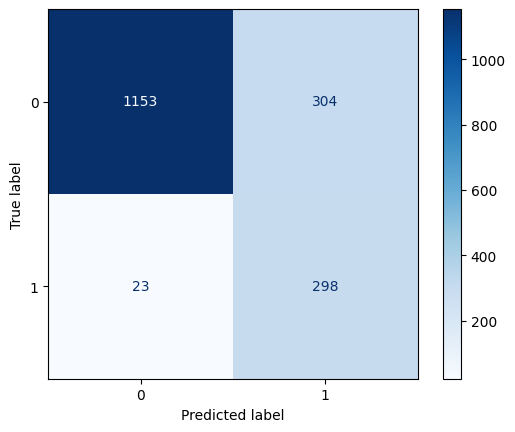

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")

In [43]:
test_df.gpt_confidence.describe()

count    1778.000000
mean        3.760405
std         1.187994
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: gpt_confidence, dtype: float64